In [2]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D,MaxPooling2D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
from IPython.display import Image
import datetime
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map
import random

In [4]:
def load_audio(file_path, sample_rate=16000):
    audio, _ = librosa.load(file_path, sr=sample_rate)
    return audio


In [5]:
def normalize_audio(audio):
    return librosa.util.normalize(audio)


In [6]:
def to_mono(audio):
    if audio.ndim > 1:
        return librosa.to_mono(audio)
    return audio


In [7]:
def extract_mfccs(audio, sample_rate=16000, n_mfcc=23):
    """
    Extract MFCCs from audio data.

    Parameters:
    audio (np.ndarray): Audio data.
    sample_rate (int): Sample rate of the audio data.
    n_mfcc (int): Number of MFCCs to extract.

    Returns:
    np.ndarray: MFCCs of the audio data.
    """
    return librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)


In [8]:
def extract_spectrogram(audio):
    stft = np.abs(librosa.stft(audio))
    return librosa.amplitude_to_db(stft, ref=np.max)


In [9]:
# def sample_audio_files(speaker_dir):
#     """
#     Get all audio files from a speaker's directory and its subdirectories.

#     Parameters:
#     speaker_dir (str): Path to the speaker's directory.

#     Returns:
#     list: List of paths to all audio files in the directory and its subdirectories.
#     """
#     all_files = []
#     for root, _, files in os.walk(speaker_dir):
#         audio_files = [os.path.join(root, f) for f in files if f.endswith('.wav')]
#         all_files.extend(audio_files)

#     return all_files

In [10]:
def sample_audio_files(speaker_dir, sample_limit):
    """
    Get all audio files from a speaker's directory.

    Parameters:
    speaker_dir (str): Path to the speaker's directory.
    sample_limit (int): Number of audio files to sample.

    Returns:
    list: List of paths to all audio files in the directory.
    """
    all_files = []
    for video_id in os.listdir(speaker_dir):
        video_dir = os.path.join(speaker_dir, video_id)
        if os.path.isdir(video_dir):
            audio_files = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.wav')]
            all_files.extend(audio_files)

    if sample_limit is not None and sample_limit < len(all_files):
        # Randomly sample the files if sample_limit is provided
        sampled_files = random.sample(all_files, sample_limit)
    else:
        # Otherwise, use all the files
        sampled_files = all_files

    return sampled_files

In [11]:
def process_audio_files(files, sample_rate=16000, feature_type='mfcc'):
    """
    Process the sampled audio files.

    Parameters:
    files (list): List of audio file paths.
    sample_rate (int): Sample rate for audio processing.
    feature_type (str): Type of feature to extract ('mfcc' or 'spectrogram').

    Returns:
    list: List of extracted features from the processed audio files.
    """
    processed_features = []

    for file_path in tqdm(files, desc="Processing audio files"):
        audio = load_audio(file_path, sample_rate)
        audio = normalize_audio(audio)
        audio = to_mono(audio)

        if feature_type == 'mfcc':
            feature = extract_mfccs(audio, sample_rate)
        elif feature_type == 'spectrogram':
            feature = extract_spectrogram(audio)

        processed_features.append(feature)

    return processed_features

In [12]:
# def preprocess_voxceleb1(root_dir, sample_rate=16000, feature_type='mfcc'):
#     """
#     Preprocess the VoxCeleb1 dataset.

#     Parameters:
#     root_dir (str): Root directory of the VoxCeleb1 dataset.
#     sample_rate (int): Target sample rate for the audio files.
#     feature_type (str): Type of feature to extract ('mfcc' or 'spectrogram').

#     Returns:
#     dict: Dictionary with speaker IDs as keys and lists of processed features as values.
#     """
#     processed_data = {}

#     speaker_dirs = os.listdir(root_dir)
#     for speaker_id in tqdm(speaker_dirs, desc="Processing speakers"):
#         speaker_dir = os.path.join(root_dir, speaker_id)
#         if os.path.isdir(speaker_dir):
#             audio_files = sample_audio_files(speaker_dir)
#             processed_data[speaker_id] = process_audio_files(audio_files, sample_rate, feature_type)

#     return processed_data

In [13]:
def preprocess_voxceleb1(root_dir, sample_rate=16000, sample_limit=None, feature_type='mfcc'):
    """
    Preprocess the VoxCeleb1 dataset.

    Parameters:
    root_dir (str): Root directory of the VoxCeleb1 dataset.
    sample_rate (int): Target sample rate for the audio files.
    sample_limit (int): Max number of audio samples to process per speaker.
    feature_type (str): Type of feature to extract ('mfcc' or 'spectrogram').

    Returns:
    dict: Dictionary with speaker IDs as keys and lists of processed features as values.
    """
    processed_data = {}

    speaker_dirs = os.listdir(root_dir)
    for speaker_id in tqdm(speaker_dirs, desc="Processing speakers"):
        speaker_dir = os.path.join(root_dir, speaker_id)
        if os.path.isdir(speaker_dir):
            # Sample audio files with the specified limit
            audio_files = sample_audio_files(speaker_dir, sample_limit)
            
            # Ensure each person has the same number of audio files
            if sample_limit is not None:
                # Count the number of audio files for this speaker
                num_files = len(audio_files)
                
                # If there are more files than the limit, sample a subset
                if num_files > sample_limit:
                    audio_files = random.sample(audio_files, sample_limit)
                elif num_files < sample_limit:
                    # If there are fewer files, duplicate randomly until reaching the limit
                    while len(audio_files) < sample_limit:
                        audio_files.extend(random.sample(audio_files, min(sample_limit - len(audio_files), num_files)))
            
            # Process the sampled audio files
            processed_data[speaker_id] = process_audio_files(audio_files, sample_rate, feature_type)

    return processed_data

In [14]:
base_path = 'D:\\VoiceRecognitionData\\Train\\wav'
processed_data = preprocess_voxceleb1(base_path, sample_rate=16000, sample_limit = 50, feature_type='mfcc')

Processing speakers:   0%|          | 0/1211 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
def inspect_data(processed_data, num_samples=5):
    """
    Inspect a few samples from the dataset.

    Parameters:
    processed_data (dict): The preprocessed dataset.
    num_samples (int): Number of samples to inspect from each speaker.

    Returns:
    None
    """
    for speaker_id, features in list(processed_data.items())[:num_samples]:
        print(f"Speaker: {speaker_id}, Number of samples: {len(features)}")
        print("Sample features:", features[0] if features else 'No data')


In [16]:
inspect_data(processed_data)

Speaker: id10001, Number of samples: 50
Sample features: [[-2.10593048e+02 -2.31916534e+02 -2.87035126e+02 ... -2.02530075e+02
  -1.27121994e+02 -9.62537231e+01]
 [ 1.30881348e+02  1.16485214e+02  7.89360504e+01 ...  1.57957345e-01
   5.87244568e+01  1.04523499e+02]
 [-3.41130185e+00 -1.24033394e+01 -3.00571480e+01 ...  3.63577919e+01
   2.30947342e+01 -2.54986405e+00]
 ...
 [-1.65498447e+01 -1.42980404e+01 -5.52450848e+00 ... -1.26808338e+01
  -1.28100910e+01 -9.41136360e+00]
 [ 2.26100373e+00  4.08800888e+00  3.42310715e+00 ... -3.15684021e-01
   3.78897882e+00  3.72014284e+00]
 [-1.04630299e+01 -1.03992462e+01 -5.73705077e-01 ... -9.20972061e+00
  -9.09234047e+00 -4.76219702e+00]]
Speaker: id10002, Number of samples: 50
Sample features: [[-121.7242     -122.06181    -171.59775    ... -186.4161
  -195.74298    -212.96141   ]
 [ 129.56471     147.3804      151.25409    ...  172.40657
   160.84523     145.57877   ]
 [ -42.801956    -72.94125     -78.80856    ...  -66.59157
   -63.00943

In [17]:
def check_feature_consistency(processed_data):
    """
    Check if features are consistent in shape across different samples.

    Parameters:
    processed_data (dict): The preprocessed dataset.

    Returns:
    bool: True if consistent, False otherwise.
    """
    feature_shapes = [feature.shape for speaker in processed_data.values() for feature in speaker]
    if all(shape == feature_shapes[0] for shape in feature_shapes):
        print("All features are consistent in shape.")
        return True
    else:
        print("Inconsistent feature shapes found.")
        return False

In [18]:
check_feature_consistency(processed_data)

Inconsistent feature shapes found.


False

In [19]:
# import numpy as np

# def pad_features_to_average_length(processed_data):
#     """
#     Pad the features in the dataset to the average length of features.

#     Parameters:
#     processed_data (dict): The preprocessed dataset.

#     Returns:
#     dict: The padded dataset.
#     """
#     # Calculate the average length
#     total_length = sum(feature.shape[1] for speaker in processed_data.values() for feature in speaker)
#     num_features = sum(len(speaker) for speaker in processed_data.values())
#     average_length = int(total_length / num_features)

#     # Pad or truncate features to the average length
#     padded_data = {}
#     for speaker_id, features in processed_data.items():
#         padded_features = []
#         for feature in features:
#             if feature.shape[1] < average_length:
#                 # Pad the feature
#                 padding = np.zeros((feature.shape[0], average_length - feature.shape[1]))
#                 padded_feature = np.hstack((feature, padding))
#             else:
#                 # Truncate the feature
#                 padded_feature = feature[:, :average_length]
#             padded_features.append(padded_feature)
#         padded_data[speaker_id] = padded_features

#     return padded_data


In [20]:
import numpy as np

def pad_features_to_percentile_length(processed_data, percentile=25):
    """
    Pad the features in the dataset to a specific percentile length of features.

    Parameters:
    processed_data (dict): The preprocessed dataset.
    percentile (int): The percentile to use for determining the target length.

    Returns:
    dict: The padded dataset.
    """
    # Calculate the percentile length
    lengths = [feature.shape[1] for speaker in processed_data.values() for feature in speaker]
    target_length = int(np.percentile(lengths, percentile))

    # Pad or truncate features to the target length
    padded_data = {}
    for speaker_id, features in processed_data.items():
        padded_features = []
        for feature in features:
            if feature.shape[1] < target_length:
                # Pad the feature
                padding = np.zeros((feature.shape[0], target_length - feature.shape[1]))
                padded_feature = np.hstack((feature, padding))
            else:
                # Truncate the feature
                padded_feature = feature[:, :target_length]
            padded_features.append(padded_feature)
        padded_data[speaker_id] = padded_features

    return padded_data



In [21]:
padded_processed_data = pad_features_to_percentile_length(processed_data, percentile=25)

In [22]:
check_feature_consistency(padded_processed_data)

All features are consistent in shape.


True

In [23]:
from sklearn.model_selection import train_test_split

def split_dataset(processed_data, test_size=0.2, val_size=0.1):
    """
    Split the dataset into training, validation, and test sets.

    Parameters:
    processed_data (dict): The preprocessed dataset.
    test_size (float): Proportion of the dataset to include in the test split.
    val_size (float): Proportion of the training dataset to include in the validation split.

    Returns:
    tuple: (train_set, val_set, test_set)
    """
    # Flatten the data and create labels
    X, y = [], []
    for speaker_id, features in processed_data.items():
        for feature in features:
            X.append(feature)
            y.append(speaker_id)
            
    X = np.array(X)
    y = np.array(y)
    
    # One-hot encode the labels
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    y_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    

    # First split to separate out the test set
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, stratify=y)

    # Second split to separate out the validation set
    val_size_adjusted = val_size / (1 - test_size)  # Adjust val size based on the reduced training set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size_adjusted, stratify=y_train)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [24]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(padded_processed_data)

C:\Users\bradl\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
from collections import Counter

def check_dataset_balance(processed_data):
    """
    Check if the dataset is balanced in terms of the number of samples per class.

    Parameters:
    processed_data (dict): The preprocessed dataset.

    Returns:
    bool: True if balanced, False otherwise.
    """
    speaker_sample_counts = Counter([speaker_id for speaker_id in processed_data for _ in processed_data[speaker_id]])
    print("Sample counts per speaker:", speaker_sample_counts)
    
    if len(set(speaker_sample_counts.values())) == 1:
        print("The dataset is balanced.")
        return True
    else:
        print("The dataset is not balanced.")
        return False

In [26]:
check_dataset_balance(padded_processed_data)

Sample counts per speaker: Counter({'id10001': 50, 'id10002': 50, 'id10003': 50, 'id10004': 50, 'id10005': 50, 'id10006': 50, 'id10007': 50, 'id10008': 50, 'id10009': 50, 'id10010': 50, 'id10011': 50, 'id10012': 50, 'id10013': 50, 'id10014': 50, 'id10015': 50, 'id10016': 50, 'id10017': 50, 'id10018': 50, 'id10019': 50, 'id10020': 50, 'id10021': 50, 'id10022': 50, 'id10023': 50, 'id10024': 50, 'id10025': 50, 'id10026': 50, 'id10027': 50, 'id10028': 50, 'id10029': 50, 'id10030': 50, 'id10031': 50, 'id10032': 50, 'id10033': 50, 'id10034': 50, 'id10035': 50, 'id10036': 50, 'id10037': 50, 'id10038': 50, 'id10039': 50, 'id10040': 50, 'id10041': 50, 'id10042': 50, 'id10043': 50, 'id10044': 50, 'id10045': 50, 'id10046': 50, 'id10047': 50, 'id10048': 50, 'id10049': 50, 'id10050': 50, 'id10051': 50, 'id10052': 50, 'id10053': 50, 'id10054': 50, 'id10055': 50, 'id10056': 50, 'id10057': 50, 'id10058': 50, 'id10059': 50, 'id10060': 50, 'id10061': 50, 'id10062': 50, 'id10063': 50, 'id10064': 50, 'id1

True

In [27]:
padded_processed_data["id10082"]

[array([[-180.63343811,  -96.95424652,  -48.64018631, ...,    0.        ,
            0.        ,    0.        ],
        [ 168.4289856 ,  143.94851685,  100.77442932, ...,    0.        ,
            0.        ,    0.        ],
        [  41.5737381 ,   -8.36346245,  -32.18199539, ...,    0.        ,
            0.        ,    0.        ],
        ...,
        [  -4.5681181 ,   -5.75896168,   -9.65508461, ...,    0.        ,
            0.        ,    0.        ],
        [  -0.66107821,  -10.50365543,  -17.75180054, ...,    0.        ,
            0.        ,    0.        ],
        [   2.67836165,    5.67190981,    5.07936954, ...,    0.        ,
            0.        ,    0.        ]]),
 array([[-578.62604  , -578.62604  , -578.62604  , ..., -169.45543  ,
         -164.57309  , -163.66446  ],
        [   0.       ,    0.       ,    0.       , ...,  -24.243195 ,
          -24.526459 ,   -9.869892 ],
        [   0.       ,    0.       ,    0.       , ...,   45.577774 ,
           47.7

# EDA

In [28]:
def plot_random_mfccs_from_dict(data_dict, num_samples=10):
    """
    Plots random MFCCs for a specified number of samples from different speakers in the dataset.

    Parameters:
    data_dict (dict): Dictionary with speaker IDs as keys and lists of arrays of MFCC data as values.
    num_samples (int): Total number of random samples to plot.
    """
    speaker_ids = list(data_dict.keys())
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot

    for i in range(num_samples):
        # Randomly select a speaker
        speaker = random.choice(speaker_ids)
        # Randomly select a sample from the chosen speaker
        sample_index = random.randint(0, len(data_dict[speaker]) - 1)
        mfcc_sample = data_dict[speaker][sample_index]

        axes[i].set_title(f'Speaker {speaker}, Sample {sample_index}')
        librosa.display.specshow(mfcc_sample, x_axis='time', ax=axes[i])
        axes[i].label_outer()  # Hide labels except for the bottom plot

    plt.tight_layout()
    plt.show()

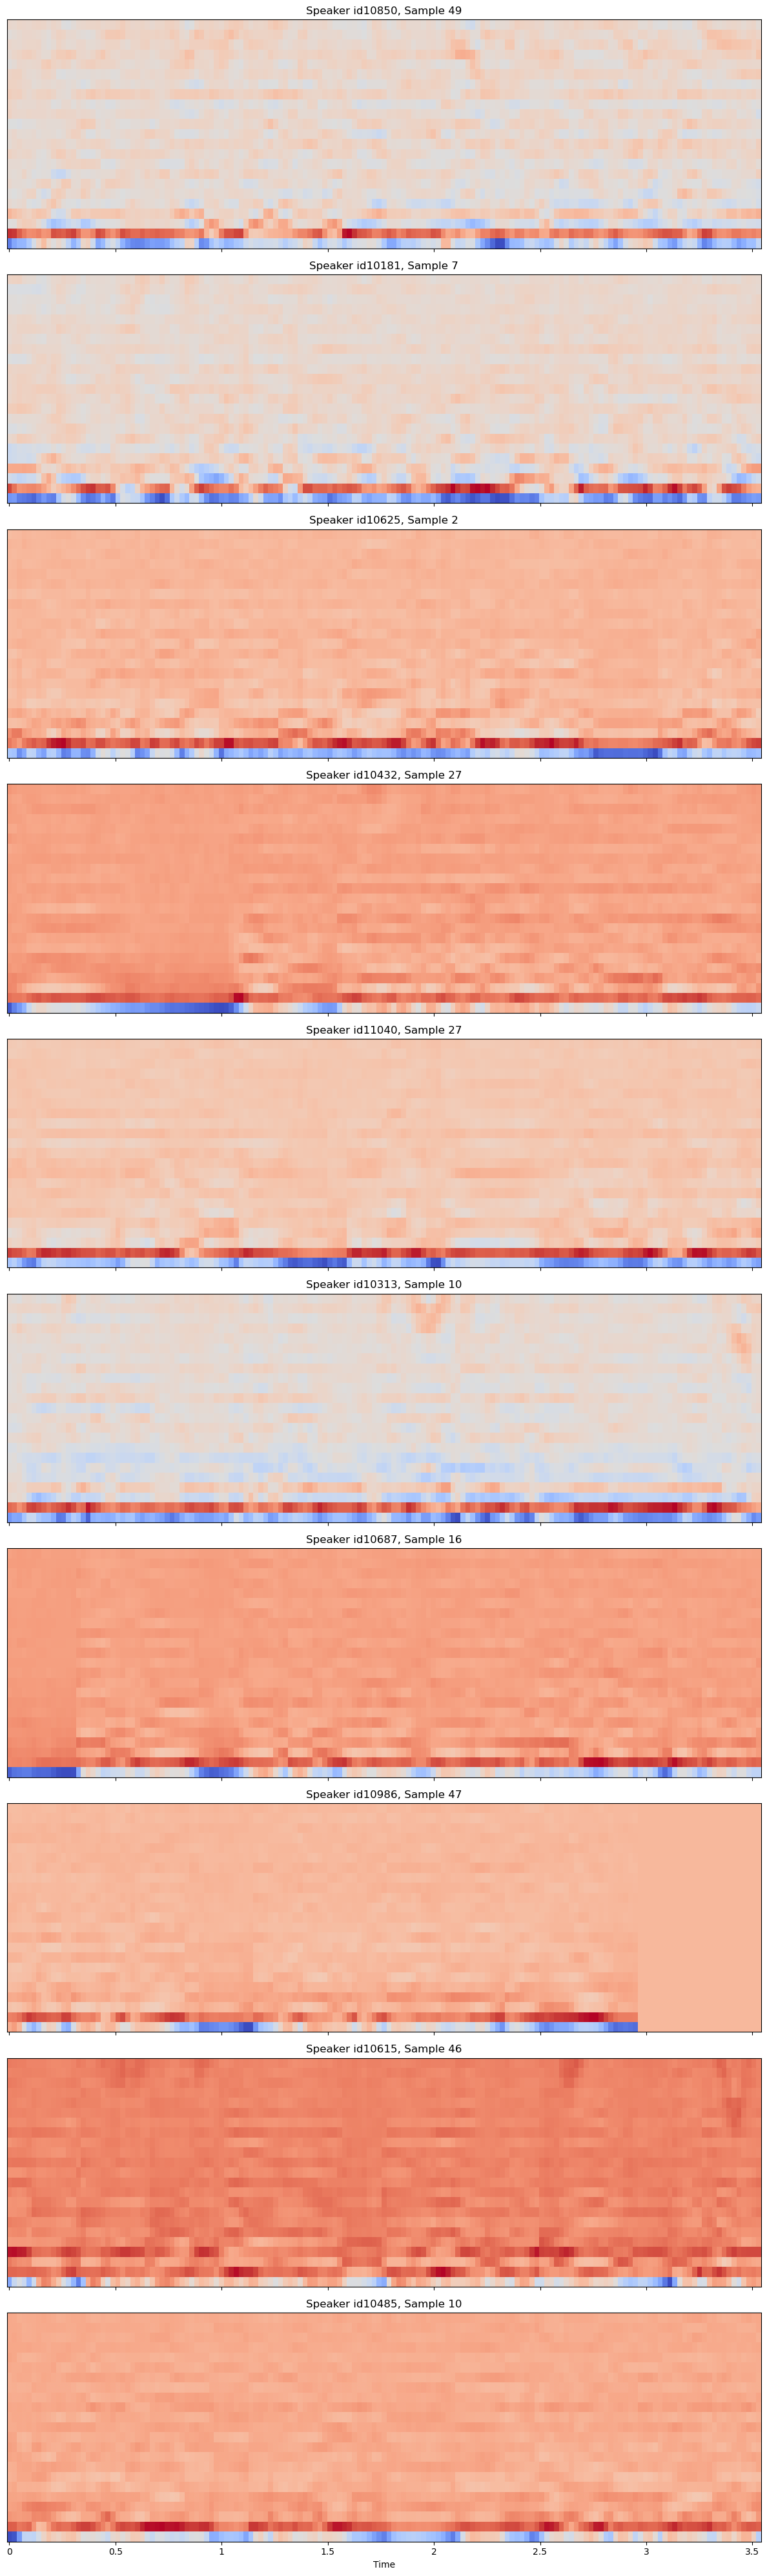

In [29]:
# Example usage:
plot_random_mfccs_from_dict(padded_processed_data, num_samples=10)

# Model 1

In [30]:
def build_cnn_lstm_model(input_shape, num_classes, filters=64, kernel_size=3, pool_size=2, lstm_units=64, dropout_rate=0.5):
    """
    Build a CNN-LSTM model for classification.

    Parameters:
    input_shape (tuple): Shape of the input features (timesteps, features).
    num_classes (int): Number of classes in the target output.
    filters (int): Number of filters in the Conv layer.
    kernel_size (int): Size of the kernel in the Conv layer.
    pool_size (int): Size of the pooling window in the MaxPooling layer.
    lstm_units (int): Number of units in the LSTM layer.
    dropout_rate (float): Dropout rate for regularization.

    Returns:
    keras.Model: The constructed CNN-LSTM model.
    """
    model = Sequential()

    # Convolutional layer
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout_rate))

    # LSTM layer
    model.add(LSTM(lstm_units))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Dense layer
    model.add(Dense(units=64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Flatten())  # Flatten before passing to the Dense layer
    model.add(Dense(num_classes, activation='softmax'))

    return model



In [31]:
def compile_model(model):
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [32]:
# Check the input shape
input_shape = X_train[0].shape
print("Input Shape:", input_shape)

# Check the number of classes
num_classes = y_train.shape[1]
print("Number of Classes:", num_classes)

Input Shape: (23, 153)
Number of Classes: 1211


In [33]:
# Check the shape of the labels
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

# Assuming you have more than 1 class, check the number of unique classes
num_classes = y_train.shape[1]  # Number of columns in y_train represents the number of classes
print("Number of classes:", num_classes)

# Examine the first few labels
print("First 5 labels in y_train:")
print(y_train[:5])

Shape of y_train: (42385, 1211)
Shape of y_val: (6055, 1211)
Number of classes: 1211
First 5 labels in y_train:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
# Assuming y_train is correctly one-hot encoded and has the shape (16954, 1211)
num_classes = y_train.shape[1]

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, mode='min', verbose=1)

# Build the model with the correct number of output neurons
model = build_cnn_lstm_model(X_train[0].shape, num_classes)

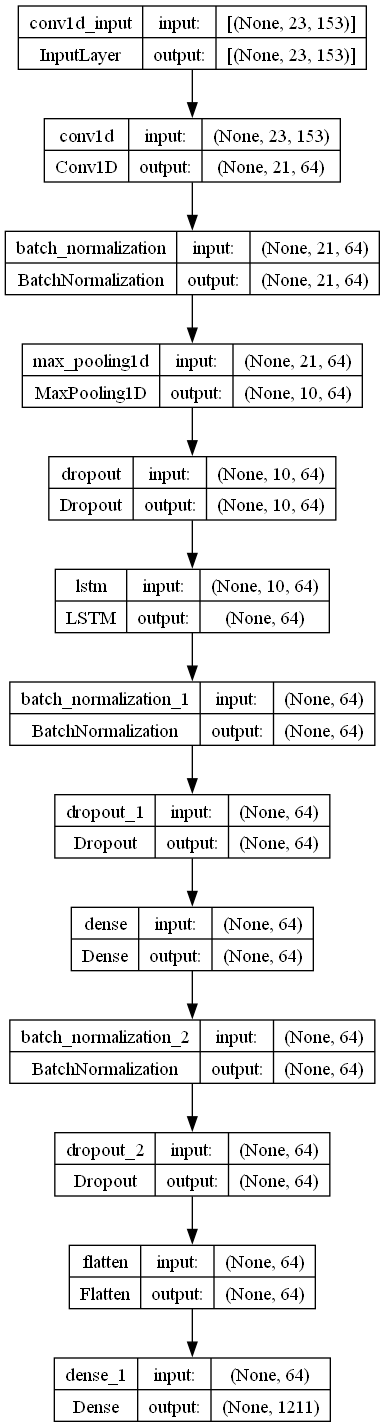

In [35]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Then train your model
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=500, 
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/500
1325/1325 [==============================] - 211s 156ms/step - loss: 7.0290 - accuracy: 0.0025 - val_loss: 6.7737 - val_accuracy: 0.0051
Epoch 2/500
1325/1325 [==============================] - 277s 209ms/step - loss: 6.7641 - accuracy: 0.0054 - val_loss: 6.4640 - val_accuracy: 0.0132
Epoch 3/500
1325/1325 [==============================] - 382s 289ms/step - loss: 6.4429 - accuracy: 0.0100 - val_loss: 6.0143 - val_accuracy: 0.0314
Epoch 4/500
1325/1325 [==============================] - 355s 268ms/step - loss: 6.1485 - accuracy: 0.0167 - val_loss: 5.6683 - val_accuracy: 0.0528
Epoch 5/500
1325/1325 [==============================] - 312s 235ms/step - loss: 5.9804 - accuracy: 0.0224 - val_loss: 5.5145 - val_accuracy: 0.0598
Epoch 6/500
1325/1325 [==============================] - 407s 307ms/step - loss: 5.8758 - accuracy: 0.0258 - val_loss: 5.3958 - val_accuracy: 0.0740
Epoch 7/500
1325/1325 [==============================] - 333s 251ms/step - loss: 5.7956 - accuracy: 0.0297

Epoch 56/500
1325/1325 [==============================] - 237s 179ms/step - loss: 5.0212 - accuracy: 0.0859 - val_loss: 4.3234 - val_accuracy: 0.2150
Epoch 57/500
1325/1325 [==============================] - 223s 168ms/step - loss: 5.0092 - accuracy: 0.0892 - val_loss: 4.3168 - val_accuracy: 0.2058
Epoch 58/500
1325/1325 [==============================] - 264s 199ms/step - loss: 5.0173 - accuracy: 0.0866 - val_loss: 4.3202 - val_accuracy: 0.2058
Epoch 59/500
1325/1325 [==============================] - 345s 261ms/step - loss: 5.0081 - accuracy: 0.0882 - val_loss: 4.2816 - val_accuracy: 0.2197
Epoch 60/500
1325/1325 [==============================] - 329s 248ms/step - loss: 5.0031 - accuracy: 0.0898 - val_loss: 4.2931 - val_accuracy: 0.2149
Epoch 61/500
1325/1325 [==============================] - 337s 255ms/step - loss: 5.0046 - accuracy: 0.0901 - val_loss: 4.3022 - val_accuracy: 0.2134
Epoch 62/500
1325/1325 [==============================] - 332s 251ms/step - loss: 4.9931 - accuracy:

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

379/379 [==============================] - 22s 59ms/step - loss: 4.2069 - accuracy: 0.2248
Test Accuracy: 0.22477291524410248


# Model 2

In [38]:
def cnn_lstm_classifier_2(input_shape, num_classes):
    """
    Build a CNN-LSTM model for audio classification using MFCC features.

    Parameters:
    input_shape (tuple): Shape of the input features (e.g., (timesteps, mfcc_features, 1)).
    num_classes (int): Number of classes in the target output.

    Returns:
    keras.Model: The constructed CNN-LSTM model.
    """
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(20, 254, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output before feeding into LSTM
    model.add(Flatten())

    # Dense layer for feature interpretation
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Reshape the output for LSTM layer
    model.add(Reshape((-1, 64)))  
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Additional Dense layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [39]:
# Check the input shape
input_shape = X_train[0].shape
print("Input Shape:", input_shape)

# Check the number of classes
num_classes = y_train.shape[1]
print("Number of Classes:", num_classes)

Input Shape: (23, 153)
Number of Classes: 1211


In [40]:
# Check the shape of the labels
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

# Assuming more than 1 class, check the number of unique classes
num_classes = y_train.shape[1]  
print("Number of classes:", num_classes)

# Examine the first few labels
print("First 5 labels in y_train:")
print(y_train[:5])

Shape of y_train: (42385, 1211)
Shape of y_val: (6055, 1211)
Number of classes: 1211
First 5 labels in y_train:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [41]:
# Assuming y_train is correctly one-hot encoded and has the shape (16954, 1211)
num_classes = y_train.shape[1]

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, mode='min', verbose=1)

# Build the model with the correct number of output neurons
model_2 = cnn_lstm_classifier_2(X_train[0].shape, num_classes)

# Compile the model with an appropriate loss function and optimizer
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

l
history = model_2.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=500, 
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/500


ValueError: in user code:

    File "C:\Users\bradl\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\bradl\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\bradl\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\bradl\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\bradl\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\bradl\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 20, 254, 1), found shape=(None, 23, 153)


In [ ]:
test_loss, test_accuracy = model_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")